In [15]:
import math

## CProfile Wrapper

In [16]:
import cProfile
import pstats
import pandas as pd
from io import StringIO
import os

from pympler.asizeof import asizeof

# Initialize the DataFrame
profile_data = pd.DataFrame(columns=["tree_type", "order", "operation", "cumulative_time", "tree_size"])

def profile(tree_type=None, order=None, operation=None, tree_size=None):
    def decorator(func):
        def wrapper(*args, **kwargs):
            profiler = cProfile.Profile()
            profiler.enable()
            result = func(*args, **kwargs)
            profiler.disable()
            s = StringIO()
            ps = pstats.Stats(profiler, stream=s).strip_dirs().sort_stats('cumulative')

            # Extract cumulative time for the specific function
            cumulative_time = None
            for key, value in ps.stats.items():
                if func.__name__ == key[2]:  # Check if the function name matches
                    cumulative_time = value[3]  # Extract cumulative time
                    break

            # Add a new row to the DataFrame
            if cumulative_time is not None:
                global profile_data
                profile_data = pd.concat([
                    profile_data,
                    pd.DataFrame([{
                        "tree_type": tree_type.__name__,
                        "order": order,
                        "operation": operation,
                        "cumulative_time": cumulative_time,
                        "tree_size": tree_size
                    }])
                ], ignore_index=True)

            return result
        return wrapper
    return decorator

## B Tree Implementation

In [17]:
def validate_btree(node, t, depth=0, leaf_depths=None):
    if leaf_depths is None:
        leaf_depths = []

    # Check keys and children consistency
    if len(node.children) != len(node.keys) + 1 and not node.leaf:
        print(f"Invalid node at depth {depth}: keys={node.keys}, children={len(node.children)}")
        return False

    # Check for minimum and maximum keys in non-root nodes
    if depth > 0 and (len(node.keys) < math.ceil(t / 2) - 1 or len(node.keys) > t - 1):
        print(f"Invalid key count in node at depth {depth}: {node.keys}")
        return False

    # Check for leaf depths consistency
    if node.leaf:
        leaf_depths.append(depth)
    else:
        for child in node.children:
            if not validate_btree(child, t, depth + 1, leaf_depths):
                return False

    # Ensure all leaves are at the same depth
    if depth == 0 and len(set(leaf_depths)) > 1:
        print(f"Leaves are at inconsistent depths: {leaf_depths}")
        return False

    return True

def val_btree(tree):
    return validate_btree(tree.root, tree.t)

### BTree Node

In [18]:
from array import array

class BTreeNode:
    def __init__(self, leaf=False):
        self.leaf = leaf
        self.keys = array('i')
        self.children = []

    def __repr__(self):
        if self.leaf:
            return f"Leaf(keys={list(self.keys)})"
        else:
            children_repr = ", ".join(repr(child) if child else "None" for child in self.children)
            return f"Internal(keys={list(self.keys)}, children=[{children_repr}])"

### BTree

In [19]:
class BTree:
    def __init__(self, t):
        self.root = BTreeNode(True)
        self.t = t

    def insert(self, k):
        root = self.root
        if len(root.keys) == 2 * self.t - 1:  # Maximum number of keys
            temp = BTreeNode(leaf=False)  # New root is not a leaf
            temp.children.append(self.root)
            self.root = temp
            self.split_child(temp, 0)
            self.insert_non_full(temp, k)
        else:
            self.insert_non_full(root, k)

    def insert_non_full(self, x, k):
        i = len(x.keys) - 1
        if x.leaf:
            # Insert the key in the correct position
            x.keys = array('i', list(x.keys) + [0]) # Add a placeholder for the new key
            while i >= 0 and k < x.keys[i]:
                x.keys[i + 1] = x.keys[i]
                i -= 1
            x.keys[i + 1] = k
        else:
            # Find the child to recurse into
            while i >= 0 and k < x.keys[i]:
                i -= 1
            i += 1
            # Split the child if it's full
            if len(x.children[i].keys) == 2 * self.t - 1:
                self.split_child(x, i)
                if k > x.keys[i]:
                    i += 1
            self.insert_non_full(x.children[i], k)

    def split_child(self, x, i):
        t = self.t
        y = x.children[i]
        z = BTreeNode(y.leaf)  # New node has the same leaf status
        mid = (t - 1) // 2

        # Adjust keys
        x.keys.insert(i, y.keys[mid])
        z.keys = y.keys[mid + 1:]
        y.keys = y.keys[:mid]

        # Adjust children if not leaf
        if not y.leaf:
            z.children = y.children[mid + 1:]
            y.children = y.children[:mid + 1]

        x.children.insert(i + 1, z)

    def delete(self, k):
        self._delete(self.root, k)
        if len(self.root.keys) == 0 and not self.root.leaf:
            self.root = self.root.children[0]

    def _delete(self, x, k):
        t_min = math.ceil(self.t / 2) - 1  # Minimum keys
        i = 0
        while i < len(x.keys) and k > x.keys[i]:
            i += 1

        if x.leaf:
            if i < len(x.keys) and x.keys[i] == k:
                x.keys.pop(i)  # Delete key directly from leaf
            return

        # Key found in internal node
        if i < len(x.keys) and x.keys[i] == k:
            self.delete_internal_node(x, k, i)
        else:
            # Ensure child `i` exists before accessing
            if i >= len(x.children):
                raise ValueError(f"Invalid child index {i}. Node: {x.keys}, Children: {len(x.children)}")

            # If the child is deficient, fix it
            if len(x.children[i].keys) <= t_min:
                self._fix_deficiency(x, i)

                # Recalculate `i` after fixing deficiency
                if i < len(x.keys) and k > x.keys[i]:
                    i += 1
                if i >= len(x.children):  # Revalidate index
                    i = len(x.children) - 1

            # Continue deletion in the adjusted child
            self._delete(x.children[i], k)

    def delete_internal_node(self, x, k, i):
        t_min = math.ceil(self.t / 2) - 1
        if len(x.children[i].keys) > t_min:
            predecessor = self.get_predecessor(x.children[i])
            x.keys[i] = predecessor
            self._delete(x.children[i], predecessor)
        elif len(x.children[i + 1].keys) > t_min:
            successor = self.get_successor(x.children[i + 1])
            x.keys[i] = successor
            self._delete(x.children[i + 1], successor)
        else:
            self.merge_nodes(x, i)
            self._delete(x.children[i], k)

    def get_predecessor(self, x):
        while not x.leaf:
            x = x.children[-1]
        return x.keys[-1]

    def get_successor(self, x):
        while not x.leaf:
            x = x.children[0]
        return x.keys[0]

    def _fix_deficiency(self, x, i):
        t_min = math.ceil(self.t / 2) - 1
        if i > 0 and len(x.children[i - 1].keys) > t_min:
            self.borrow_from_prev(x, i)
        elif i < len(x.children) - 1 and len(x.children[i + 1].keys) > t_min:
            self.borrow_from_next(x, i)
        else:
            if i < len(x.children) - 1:
                self.merge_nodes(x, i)
            else:
                self.merge_nodes(x, i - 1)

    def borrow_from_prev(self, x, i):
        child = x.children[i]
        sibling = x.children[i - 1]

        child.keys.insert(0, x.keys[i - 1])
        if not sibling.leaf:
            child.children.insert(0, sibling.children.pop())
        x.keys[i - 1] = sibling.keys.pop()

    def borrow_from_next(self, x, i):
        child = x.children[i]
        sibling = x.children[i + 1]

        child.keys.append(x.keys[i])
        if not sibling.leaf:
            child.children.append(sibling.children.pop(0))
        x.keys[i] = sibling.keys.pop(0)

    def merge_nodes(self, x, i):
        child = x.children[i]
        sibling = x.children[i + 1]

        child.keys.append(x.keys[i])
        child.keys.extend(sibling.keys)
        if not sibling.leaf:
            child.children.extend(sibling.children)

        x.keys.pop(i)
        x.children.pop(i + 1)

    def print_tree(self, x=None, level=0):
        if x is None:
            x = self.root
        print("Level", level, ":", len(x.keys), "keys:", x.keys)
        level += 1
        for child in x.children:
            self.print_tree(child, level)

    def search(self, key, x=None):
        if x is None:
            x = self.root  # Start from the root if no node is provided

        # Find the first key greater than or equal to the given key
        i = 0
        while i < len(x.keys) and key > x.keys[i]:
            i += 1

        # If the key is found in the current node
        if i < len(x.keys) and key == x.keys[i]:
            return x, i

        # If the node is a leaf, the key is not present
        if x.leaf:
            return None

        # Otherwise, search the appropriate child
        return self.search(key, x.children[i])

    def range_search(self, low, high, x=None, results=None):
        if x is None:
            x = self.root  # Start from the root if no node is provided
        if results is None:
            results = []  # Initialize the results list

        # Traverse the current node's keys and children
        i = 0
        while i < len(x.keys) and x.keys[i] < low:
            i += 1

        while i < len(x.keys) and x.keys[i] <= high:
            # If the node is not a leaf, explore the left child
            if not x.leaf:
                self.range_search(low, high, x.children[i], results)
            # Add the key if it is within the range
            results.append(x.keys[i])
            i += 1

        # Explore the last child if it exists
        if not x.leaf and (i < len(x.children)):
            self.range_search(low, high, x.children[i], results)

        return results

In [20]:
# btree = BTree(3)

# temp = 6

# # Insert keys
# keys_to_insert = master_dataset[:temp]
# for key in keys_to_insert:
#     btree.insert(key)

# print(val_btree(btree))

# btree.print_tree()

# # Test deletion cases
# keys_to_delete = master_dataset[:temp]
# for key in keys_to_delete:
#     print(f"\n")
#     btree.print_tree()
#     print(f"\nDeleting key {key}:")
#     btree.delete(key)
# btree.print_tree()

## B+ Tree Implementation

### BPlusTree Node

### BPlusTree

In [21]:
class Node(object):
    """
    Base node object.

    Each node stores keys and values. Keys are not unique to each value,
    and as such values are stored as a list under each key.
    """
    def __init__(self, order):
        self.order = order       # Maximum number of keys
        self.keys = []
        self.values = []
        self.leaf = True         # Leaf by default; can become internal after splits

    def add(self, key, value):
        """
        Adds a key-value pair to the node (leaf).
        """
        if not self.keys:
            self.keys.append(key)
            self.values.append([value])
            return

        for i, item in enumerate(self.keys):
            if key == item:
                # Key already exists; append value to existing list
                self.values[i].append(value)
                return
            elif key < item:
                self.keys.insert(i, key)
                self.values.insert(i, [value])
                return

        # If new key is greater than all existing keys
        self.keys.append(key)
        self.values.append([value])

    def split(self):
        """
        Splits the node into two, and transforms 'self' into an internal node
        by setting:
            self.keys = [right.keys[0]]
            self.values = [left, right]
            self.leaf = False
        """
        mid = self.order // 2

        left = Node(self.order)
        right = Node(self.order)

        left.keys = self.keys[:mid]
        left.values = self.values[:mid]

        right.keys = self.keys[mid:]
        right.values = self.values[mid:]

        # 'self' becomes an internal node
        self.keys = [right.keys[0]]
        self.values = [left, right]
        self.leaf = False

    def is_full(self):
        """
        Returns True if the node is holding the maximum number of keys.
        """
        return len(self.keys) >= self.order

    def show(self, level=0):
        """
        Recursively prints the keys in the (sub)tree rooted at this node.
        """
        print("  " * level + f"Node(keys={self.keys})")
        if not self.leaf:
            for child in self.values:
                child.show(level + 1)


class BPlusTree(object):
    def __init__(self, order=4):
        self.root = Node(order)
        # For a node with 'order' keys, typical B+‐tree min. # of keys in non-root is:
        #    min_keys = ceil(order / 2)
        # This can vary by implementation. We'll define a simple threshold below:
        self.min_degree = (order + 1) // 2   # This is used to figure out minimum keys.

    def _find(self, node, key):
        """
        Given an internal node and a target key, returns (child, index)
        where 'child' is the branch of node.values[] to follow, and 'index'
        is that child's index in node.values.
        """
        for i, item in enumerate(node.keys):
            if key < item:
                return node.values[i], i
        return node.values[-1], len(node.keys)

    def _merge(self, parent, child, index):
        """
        Helper used after a leaf splits. 'child' has turned into an internal node
        containing [left_child, right_child]. Insert the pivot (child.keys[0]) into
        'parent' at the proper location, and re-link parent.values.
        """
        # Remove old pointer to 'child'
        parent.values.pop(index)

        pivot = child.keys[0]
        inserted = False

        for i, key in enumerate(parent.keys):
            if pivot < key:
                parent.keys.insert(i, pivot)
                parent.values[i:i] = child.values
                inserted = True
                break

        if not inserted:
            # Insert at the end
            parent.keys.append(pivot)
            parent.values.extend(child.values)

    def insert(self, key, value):
        """
        Insert (key, value) into the B+ tree, splitting as needed.
        """
        if self.root.is_full() and self.root.leaf:
            # Special case: root is full and is a leaf
            self.root.split()
            # After splitting, root has 1 key and 2 children
            # We now proceed to insert into the correct child
            self._insert_non_full(self.root, key, value)
        else:
            self._insert_non_full(self.root, key, value)

    def _insert_non_full(self, node, key, value):
        """
        Insert (key, value) into node/subtree, assuming node is not full
        (or is root which may have just been split).
        """
        if node.leaf:
            node.add(key, value)
        else:
            # Find which child to descend into
            child, index = self._find(node, key)

            # If that child is full, split it before descending
            if child.is_full() and child.leaf:
                child.split()
                # After splitting, 'child' is an internal node with 2 children
                self._merge(node, child, index)
                # Determine which child to actually go down into
                # Compare 'key' with pivot (child.keys[0]) to pick left or right
                if key < node.keys[index]:
                    child = node.values[index]
                else:
                    child = node.values[index + 1]

            elif child.is_full() and not child.leaf:
                # If it's a full internal node, you would normally split it as well
                # and merge it into 'node'. This is a simplified approach:
                child.split()
                self._merge(node, child, index)
                # Decide which side to go to:
                if key < node.keys[index]:
                    child = node.values[index]
                else:
                    child = node.values[index + 1]

            # Recurse
            self._insert_non_full(child, key, value)

    def search(self, key):
        node = self.root
        while not node.leaf:
            node, _ = self._find(node, key)

        for i, item in enumerate(node.keys):
            if key == item:
                return node.values[i]
        return None

    def range_search(self, low, high):
        results = []
        self._range_search_node(self.root, low, high, results)
        return results

    def _range_search_node(self, node, low, high, results):
        if node.leaf:
            # Check all keys in this leaf
            for i, key in enumerate(node.keys):
                if low <= key <= high:
                    # Append all values associated with that key
                    results.extend(node.values[i])
        else:
            # If it's an internal node, recurse on all children.
            # (You can do more pruning if desired, but this is simple and correct.)
            for child in node.values:
                self._range_search_node(child, low, high, results)

    def delete(self, key):
        # 1) Find the leaf containing 'key'
        path = []  # Will store (node, index_in_parent) as we go down
        node = self.root
        while not node.leaf:
            child, idx = self._find(node, key)
            path.append((node, idx))
            node = child

        # 2) Remove the key (and possibly its values) from the leaf
        deleted_index = None
        for i, item in enumerate(node.keys):
            if item == key:
                # Remove one value from the associated list
                node.values[i].pop()
                # If that list becomes empty, remove the key entirely
                if not node.values[i]:
                    node.keys.pop(i)
                    node.values.pop(i)
                deleted_index = i
                break

        # If the key wasn't found, nothing to delete
        if deleted_index is None:
            return

        # 3) Rebalance upward if needed
        self._rebalance_after_delete(node, path)

    def _rebalance_after_delete(self, node, path):
        # If the node is root and it's a leaf, no rebalance needed if it still has >= 1 key
        if node == self.root:
            self._check_root_shrink()
            return

        while True:
            if self._has_enough_keys(node):
                # No rebalancing needed
                return

            # If node is the root (but not enough keys), handle root special case
            if node == self.root:
                self._check_root_shrink()
                return

            # Otherwise, get parent info from path
            if not path:
                return  # Should never happen unless node is root
            parent, parent_index = path.pop()

            # Attempt to borrow from sibling or merge
            left_sibling, right_sibling, left_index, right_index = \
                self._get_siblings(parent, node)

            # 1) Try to borrow from left sibling
            if left_sibling and len(left_sibling.keys) > self._min_keys_required():
                self._borrow_from_left(node, parent, left_sibling, left_index)
                return

            # 2) Try to borrow from right sibling
            if right_sibling and len(right_sibling.keys) > self._min_keys_required():
                self._borrow_from_right(node, parent, right_sibling, right_index)
                return

            # 3) Merge with left sibling if it exists
            if left_sibling:
                self._merge_nodes(left_sibling, node, parent)
                node = left_sibling  # merged node is 'left_sibling'
            # 4) Else merge with right sibling
            elif right_sibling:
                self._merge_nodes(node, right_sibling, parent)
                # node remains 'node' since we merged right_sibling into it

            # Now 'parent' may have lost a key/pointer; if parent is below min, continue upward
            node = parent
            if node == self.root:
                self._check_root_shrink()
                return

    def _check_root_shrink(self):
        if not self.root.leaf and len(self.root.values) == 1:
            # Only one subtree -> make it the new root
            self.root = self.root.values[0]
        # If it's a leaf but has 0 keys, it's an empty tree
        if self.root.leaf and len(self.root.keys) == 0:
            # The tree is completely empty now
            pass

    def _has_enough_keys(self, node):
        # Root can have fewer keys. For non-root:
        if node == self.root:
            return True
        return len(node.keys) >= self._min_keys_required()

    def _min_keys_required(self):
        # Because 'order' is max # of keys, let's define half:
        # e.g. if order=4 => min_degree= (4+1)//2=2 => minimum keys=2-1=1
        return self.min_degree - 1

    def _get_siblings(self, parent, node):
        left_sib = None
        right_sib = None
        left_i = None
        right_i = None

        for i, child in enumerate(parent.values):
            if child is node:
                # Check left
                if i - 1 >= 0:
                    left_sib = parent.values[i - 1]
                    left_i = i - 1
                # Check right
                if i + 1 < len(parent.values):
                    right_sib = parent.values[i + 1]
                    right_i = i + 1
                break

        return left_sib, right_sib, left_i, right_i

    def _borrow_from_left(self, node, parent, left_sib, left_i):
        # Move the last key from left_sib to the front of node
        borrowed_key = left_sib.keys.pop()
        borrowed_values = left_sib.values.pop()
        node.keys.insert(0, borrowed_key)
        node.values.insert(0, borrowed_values)

        # In a B+‐tree, the parent's pivot that separates left_sib and node
        # typically becomes node's first key. So we also update parent.keys[left_i].
        # Because parent.keys[left_i] was the first key in 'node' prior to borrowing.
        parent_key_to_update = borrowed_key
        parent.keys[left_i] = node.keys[0]  # pivot is updated

    def _borrow_from_right(self, node, parent, right_sib, right_i):
        borrowed_key = right_sib.keys.pop(0)
        borrowed_values = right_sib.values.pop(0)
        node.keys.append(borrowed_key)
        node.values.append(borrowed_values)

        # Update parent's pivot
        parent.keys[right_i - 1] = right_sib.keys[0]

    def _merge_nodes(self, left_node, right_node, parent):
        # Identify the pivot that separates left_node and right_node in 'parent'
        pivot_index = None
        for i, child in enumerate(parent.values):
            if child is left_node:
                # The pivot we want to remove from parent is parent.keys[i]
                # that leads to right_node.  That pivot might also be i or i-1
                # depending on your B+ tree pivot arrangement. We do a simple approach:
                pivot_index = i
                break

        # If pivot_index is the last child, the pivot key might be pivot_index-1
        # This can vary by implementation. Adjust if needed:
        if pivot_index is not None and pivot_index >= len(parent.keys):
            pivot_index = len(parent.keys) - 1

        # Merge keys/values
        left_node.keys.extend(right_node.keys)
        left_node.values.extend(right_node.values)

        # Remove right_node from parent.values
        parent.values.remove(right_node)

        # Remove pivot key from parent.keys
        # Usually, the pivot that belongs to right_node is at pivot_index or pivot_index-1
        if pivot_index is not None and pivot_index < len(parent.keys):
            parent.keys.pop(pivot_index)
        else:
            # fallback if pivot_index is out of range
            if parent.keys:
                parent.keys.pop()

In [22]:
# test_dataset = master_dataset[:1000]

# # Creation experiment
# test_tree = BPlusTree(3)
# create_tree(test_dataset, test_tree)
# print(f"\tsize of tree: {asizeof(test_tree)}")

# # test_tree.print_tree()

# # Search experiment
# search_tree(test_dataset, test_tree)

# delete_tree(test_dataset, test_tree)

## Tests

### Test Methods

In [23]:
import random
random.seed(0)

def generate_dataset(num_elements):
    """
    Generate a dataset of keys for testing with random distribution.

    Parameters:
        num_elements (int): Number of elements in the dataset.

    Returns:
        list: Generated dataset as a list of keys.
    """
    # Generate random integers within a specified range
    dataset = random.sample(range(num_elements * 10), num_elements)
    return dataset

def create_tree(dataset, tree):
    if isinstance(tree, BPlusTree):
        for i in dataset:
            tree.insert(i, i)   
    else:
        for i in dataset:
            tree.insert(i)

def delete_tree(dataset, tree):
    for i in dataset:
        # print(f"deleting {i}")
        tree.delete(i)
        # tree.print_tree()

def search_tree(searchables, tree):
    for i in searchables:
        tree.search(i)

def range_search_tree(pairs, tree):
    for low, high in pairs:
        tree.range_search(low, high)

In [24]:
def split_into_pairs(lst, n):
    """
    Split every n elements from a list into a list of pairs.

    Parameters:
        lst (list): The input list.
        n (int): The step size to get elements.

    Returns:
        list: A list of pairs.
    """
    # Get every n-th element
    nth_elements = lst[::n]

    # Pair consecutive elements
    pairs = list(zip(nth_elements, nth_elements[1:]))

    pairs = [sorted(pair) for pair in pairs]

    return pairs

In [25]:
def all_tests(master_dataset, dataset_sizes, orders, tree_type):
    for order in orders:
        print(f"{order=}")
        for d_size in dataset_sizes:
            print(f"{d_size=}")
            profiled_create = profile(tree_type=tree_type, order=order, operation="Insertion", tree_size=d_size)(create_tree)
            profiled_delete = profile(tree_type=tree_type, order=order, operation="Deletion", tree_size=d_size)(delete_tree)
            profiled_search = profile(tree_type=tree_type, order=order, operation="Search", tree_size=d_size)(search_tree)
            profiled_range_search = profile(tree_type=tree_type, order=order, operation="Range Search", tree_size=d_size)(range_search_tree)

            dataset = master_dataset[:d_size]

            # Creation experiment
            tree = tree_type(order)
            profiled_create(dataset, tree)
            # create_tree(dataset,tree)
            print(f"\tsize of tree: {asizeof(tree)}")

            # tree.print_tree()

            # Search experiment
            profiled_search(dataset, tree)
            # search_tree(dataset, tree)

            # Range Search experiment
            pairs = split_into_pairs(dataset, d_size // 10)
            profiled_range_search(pairs, tree)

            # Deletion experiment
            profiled_delete(dataset, tree)

### Data Collection

In [26]:
random.seed(0)

profile_data.drop(profile_data.index, inplace=True)

dataset_sizes = [10**i for i in range(1, 5)]
orders = [3,4,5]

master_dataset = generate_dataset(dataset_sizes[-1])

In [27]:
all_tests(master_dataset, dataset_sizes, orders, BTree)

order=3
d_size=10
	size of tree: 1792
d_size=100
	size of tree: 11520
d_size=1000
	size of tree: 113072
d_size=10000
	size of tree: 1152392


C:\Users\grigal\AppData\Local\Temp\ipykernel_26528\661696654.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  profile_data = pd.concat([


order=4
d_size=10
	size of tree: 1792
d_size=100
	size of tree: 9864
d_size=1000
	size of tree: 91600
d_size=10000
	size of tree: 929720
order=5
d_size=10
	size of tree: 1496
d_size=100
	size of tree: 6776
d_size=1000
	size of tree: 64048
d_size=10000
	size of tree: 636264


In [28]:
all_tests(master_dataset, dataset_sizes, orders, BPlusTree)

order=3
d_size=10
	size of tree: 3624
d_size=100
	size of tree: 28000
d_size=1000
	size of tree: 279152
d_size=10000
	size of tree: 2762960
order=4
d_size=10
	size of tree: 3344
d_size=100
	size of tree: 24384
d_size=1000
	size of tree: 225928
d_size=10000
	size of tree: 2257264
order=5
d_size=10
	size of tree: 3064
d_size=100
	size of tree: 21368
d_size=1000
	size of tree: 205320
d_size=10000
	size of tree: 2045608


In [29]:
data_bplus = {
    "tree_type": ["BPlusTree"] * 12,
    "order": [3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5],
    "d_size": [10, 100, 1000, 10000, 10, 100, 1000, 10000, 10, 100, 1000, 10000],
    "size_of_tree": [3624, 28000, 279152, 2762960, 3344, 24384, 225928, 2257264, 3064, 21368, 205320, 2045608]
}

df_bplus = pd.DataFrame(data_bplus)

data_btree = {
    "tree_type": ["BTree"] * 12,
    "order": [3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5],
    "d_size": [10, 100, 1000, 10000, 10, 100, 1000, 10000, 10, 100, 1000, 10000],
    "size_of_tree": [1808, 11632, 114248, 1164608, 1808, 9936, 92560, 939200, 1504, 6864, 64888, 644416]
}

df_btree = pd.DataFrame(data_btree)

# Combine both DataFrames
df_size = pd.concat([df_bplus, df_btree], ignore_index=True)

In [30]:
df_size

,tree_type,order,d_size,size_of_tree
0,BPlusTree,3,10,3624
1,BPlusTree,3,100,28000
2,BPlusTree,3,1000,279152
3,BPlusTree,3,10000,2762960
4,BPlusTree,4,10,3344
5,BPlusTree,4,100,24384
6,BPlusTree,4,1000,225928
7,BPlusTree,4,10000,2257264
8,BPlusTree,5,10,3064
9,BPlusTree,5,100,21368


In [31]:
profile_data

,tree_type,order,operation,cumulative_time,tree_size
0,BTree,3,Insertion,0.000043,10
1,BTree,3,Search,0.000018,10
2,BTree,3,Range Search,0.000042,10
3,BTree,3,Deletion,0.000048,10
4,BTree,3,Insertion,0.000344,100
...,...,...,...,...,...
91,BPlusTree,5,Deletion,0.007249,1000
92,BPlusTree,5,Insertion,0.244436,10000
93,BPlusTree,5,Search,0.330918,10000
94,BPlusTree,5,Range Search,0.016542,10000


## Visualization

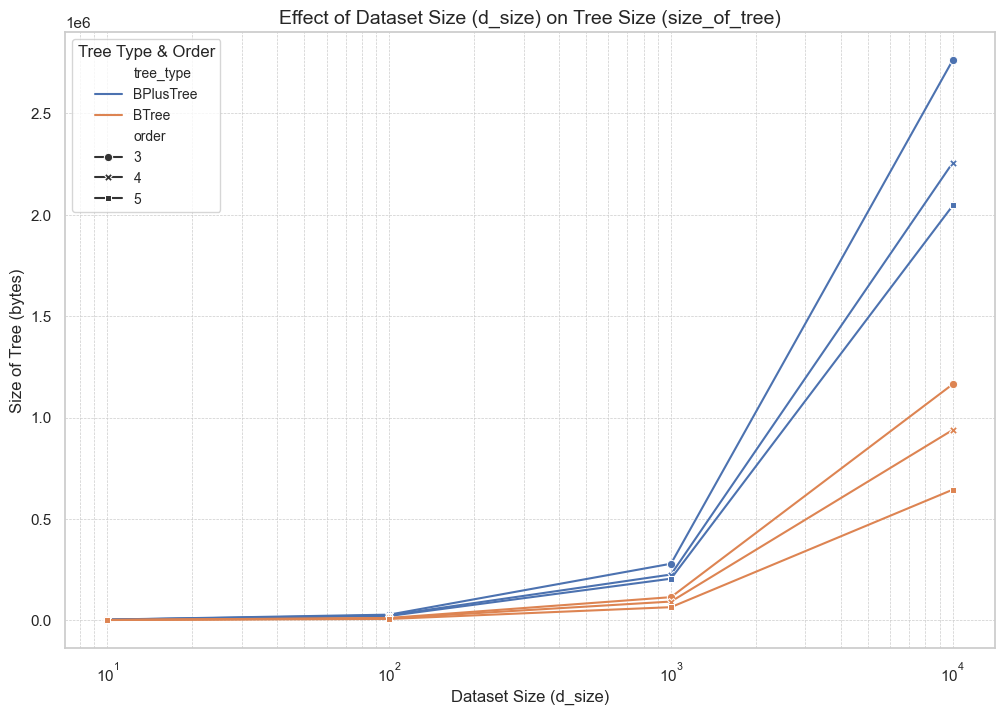

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the effect of d_size on size_of_tree for each order and tree type
sns.set(style="whitegrid")

# Create a plot for each order and tree type
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=df_size,
    x="d_size",
    y="size_of_tree",
    hue="tree_type",
    style="order",
    markers=True,
    dashes=False
)

# Set plot labels and title
plt.title("Effect of Dataset Size (d_size) on Tree Size (size_of_tree)", fontsize=14)
plt.xlabel("Dataset Size (d_size)", fontsize=12)
plt.ylabel("Size of Tree (bytes)", fontsize=12)
plt.legend(title="Tree Type & Order", fontsize=10)
plt.xscale("log")  # Log scale for better visualization
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot
plt.show()

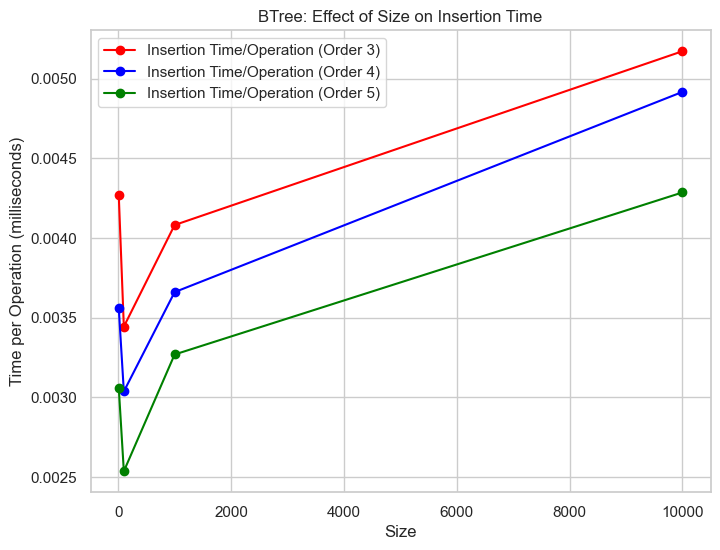

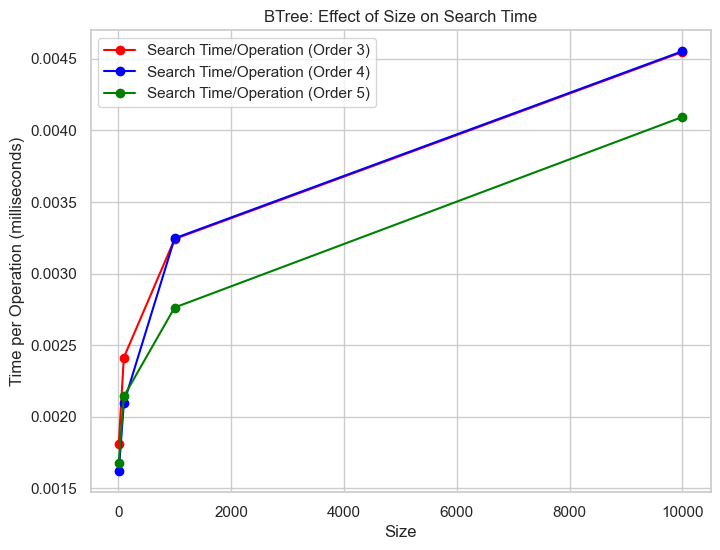

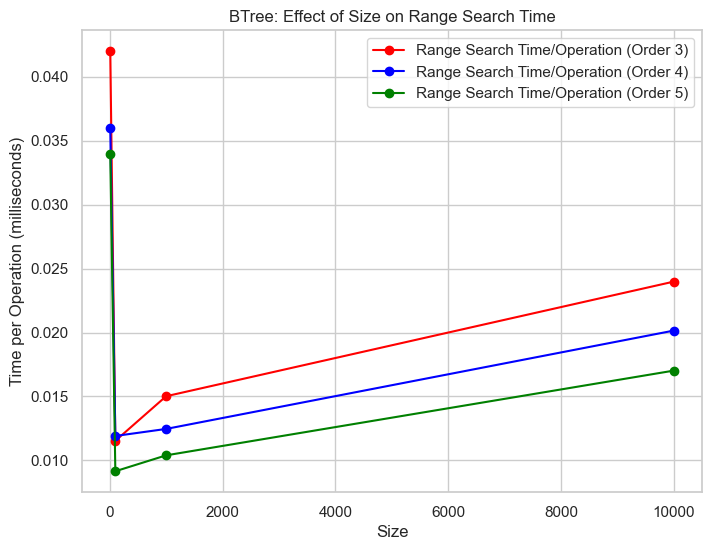

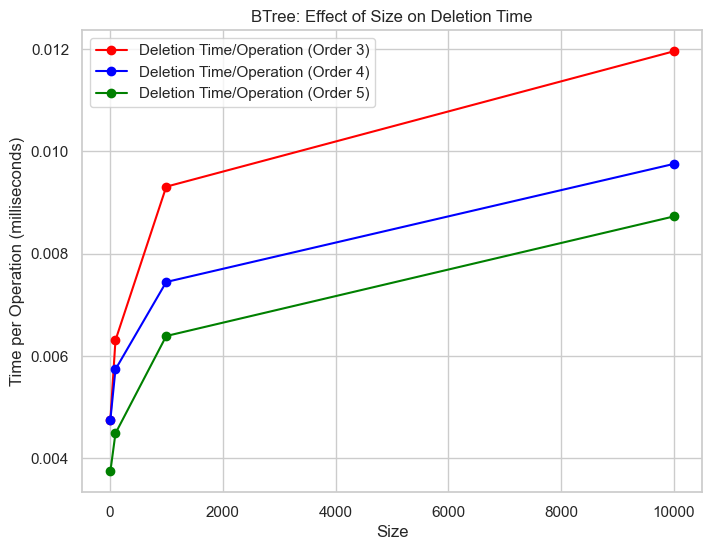

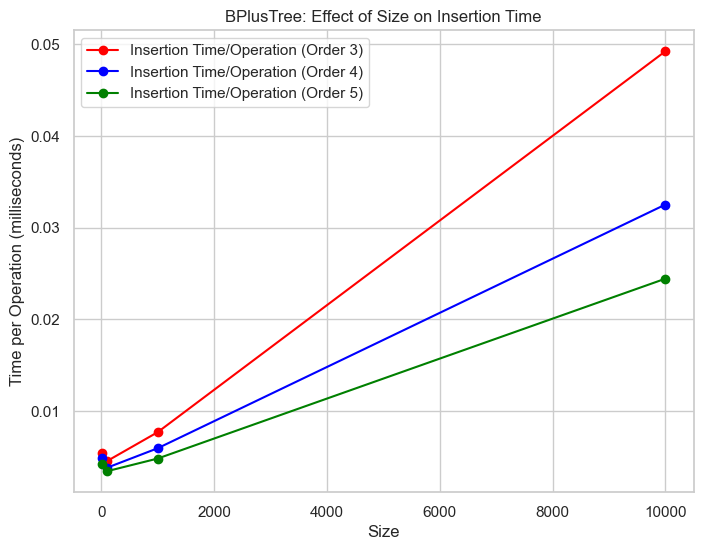

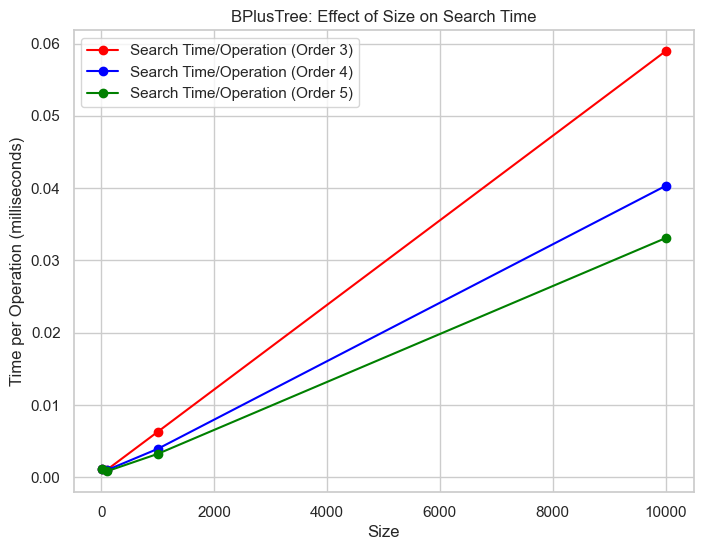

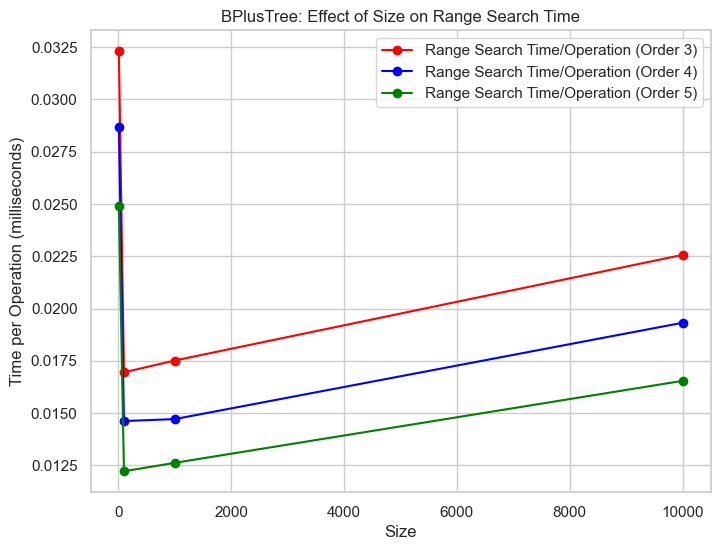

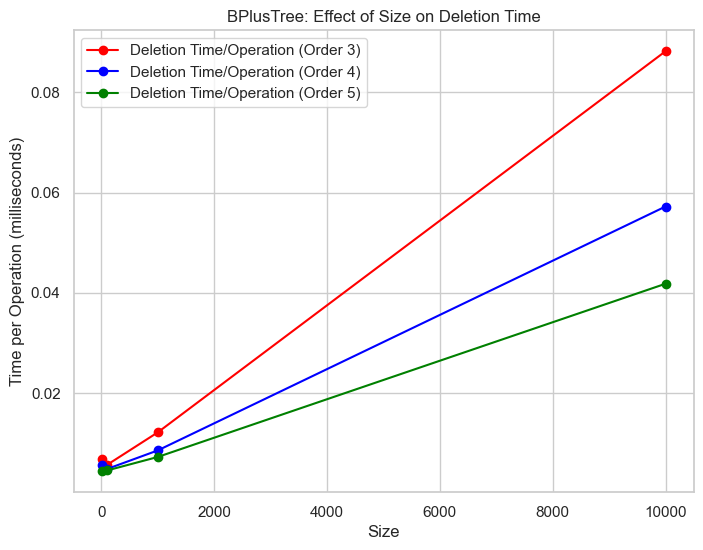

In [33]:
order_colors = {
    3: "red",
    4: "blue",
    5: "green"
}

# Filter down to just the BPlusTree rows
for tree_kind in ['BTree', 'BPlusTree']:
    df_tree = profile_data[profile_data['tree_type'] == tree_kind]

    # Get the set of operations in the BPlusTree subset
    operations = df_tree['operation'].unique()

    # --- 1) Plot cumulative time vs size for each operation ---
    for operation in operations:
        operation_data = df_tree[df_tree['operation'] == operation]

        # Group data by order and tree size, taking the mean for numeric columns only
        numeric_columns = ['cumulative_time']  # Add other numeric columns as needed
        grouped_data = operation_data.groupby(['order', 'tree_size'])[numeric_columns].mean().reset_index()

        plt.figure(figsize=(8, 6))

        # Iterate over unique orders in the grouped data
        for order in grouped_data['order'].unique():
            order_data = grouped_data[grouped_data['order'] == order]

            # Use the correct color based on the tree order
            color = order_colors.get(order, 'black')  # Default to black if order not found

            if operation == "Range Search":
                plt.plot(order_data['tree_size'],
                         order_data['cumulative_time'] / (order_data['tree_size'] // 10) * 1000,
                         marker='o',
                         label=f"Range Search Time/Operation (Order {order})", color=color)
            else:
                plt.plot(order_data['tree_size'],
                         order_data['cumulative_time'] / order_data['tree_size'] * 1000,
                         marker='o',
                         label=f"{operation} Time/Operation (Order {order})", color=color)

        plt.title(f"{tree_kind}: Effect of Size on {operation} Time")
        plt.xlabel("Size")
        plt.ylabel("Time per Operation (milliseconds)")
        plt.grid(True)
        plt.legend()
        plt.show()

In [34]:
import marimo as mo